In [3]:
import os
import torch
import numpy as np
from tqdm import tqdm

from PIL import Image
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, models, transforms

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
    
device

device(type='cuda')

In [5]:
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2_vits14 = dinov2_vits14.to(device)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /home/mhung/.cache/torch/hub/main.zip
/home/mhung/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/mhung/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/mhung/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /home/mhung/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:19<00:00, 4.54MB/s]


In [6]:
pca = PCA(n_components=3)
scaler = MinMaxScaler(clip=True)
patch_size = dinov2_vits14.patch_size

#520//14
patch_h  = 520//patch_size
patch_w  = 520//patch_size
feat_dim = 384 # vitl14

In [7]:
transform1 = transforms.Compose([
    transforms.Resize(520),
    transforms.CenterCrop(518), #should be multiple of model patch_size
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.2)
])

In [8]:
total_features  = [] 
root_path='C:/Users/PC/Downloads/DiNoV2_backup/'
folder_path=f'{root_path}/train/yes'
with torch.no_grad():
  list_img_path = ['/home/mhung/Documents/python/DinoV2_in_medical_classification/brain_tumor_dataset/Training/glioma/Tr-gl_0010.jpg','/home/mhung/Documents/python/DinoV2_in_medical_classification/brain_tumor_dataset/Training/meningioma/Tr-me_0010.jpg','/home/mhung/Documents/python/DinoV2_in_medical_classification/brain_tumor_dataset/Training/notumor/Tr-no_0010.jpg','/home/mhung/Documents/python/DinoV2_in_medical_classification/brain_tumor_dataset/Training/pituitary/Tr-pi_0010.jpg' ]
  for img_path in list_img_path:
    img = Image.open(img_path).convert('RGB')
    img_t = transform1(img).to(device)
    
    features_dict = dinov2_vits14.forward_features(img_t.unsqueeze(0))
    features = features_dict['x_norm_patchtokens']
    total_features.append(features)
total_features = torch.cat(total_features, dim=0)
total_features.shape

torch.Size([4, 1369, 384])

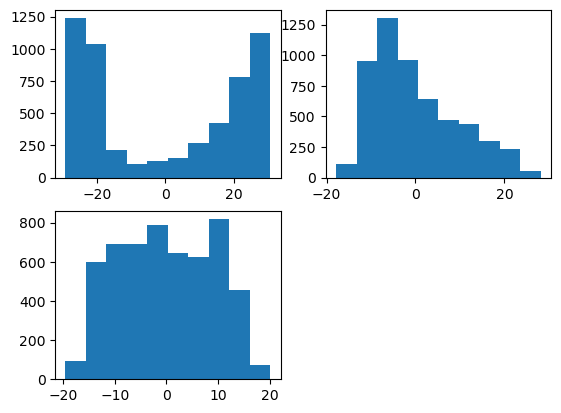

In [9]:
total_features = total_features.reshape(4 * patch_h * patch_w, feat_dim) #4(*H*w, 1024)
total_features = total_features.cpu()

pca = PCA(n_components=3)
pca.fit(total_features)
pca_features = pca.transform(total_features)

# visualize PCA components for finding a proper threshold
# 3 histograms for 3 components
plt.subplot(2, 2, 1)
plt.hist(pca_features[:, 0])
plt.subplot(2, 2, 2)
plt.hist(pca_features[:, 1])
plt.subplot(2, 2, 3)
plt.hist(pca_features[:, 2])
plt.show()
plt.close()

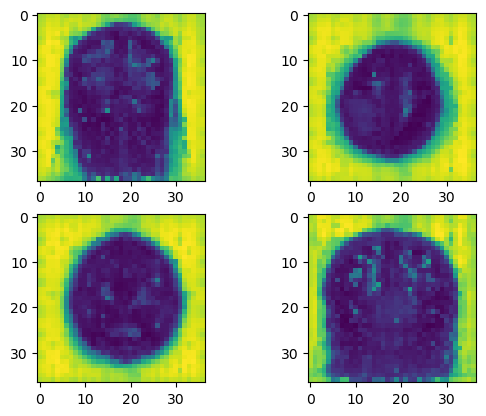

In [10]:
pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / \
                     (pca_features[:, 0].max() - pca_features[:, 0].min())
# pca_features = sklearn.processing.minmax_scale(pca_features)

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features[i*patch_h*patch_w : (i+1)*patch_h*patch_w, 0].reshape(patch_h, patch_w))

plt.show()

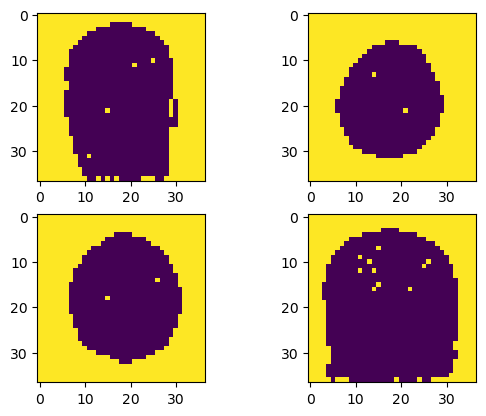

In [22]:
pca_features_bg = pca_features[:, 0] > 0.4 # from first histogram
pca_features_fg = ~pca_features_bg

# plot the pca_features_bg
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_bg[i * patch_h * patch_w: (i+1) * patch_h * patch_w].reshape(patch_h, patch_w))
plt.show()

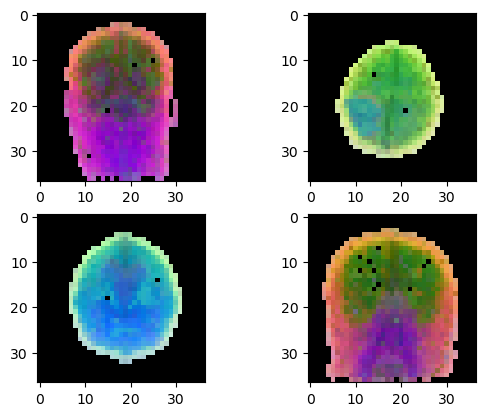

In [23]:
pca.fit(total_features[pca_features_fg]) 
pca_features_left = pca.transform(total_features[pca_features_fg])

for i in range(3):
    # min_max scaling
    pca_features_left[:, i] = (pca_features_left[:, i] - pca_features_left[:, i].min()) / (pca_features_left[:, i].max() - pca_features_left[:, i].min())

pca_features_rgb = pca_features.copy()

# for black background
pca_features_rgb[pca_features_bg] = 0
# new scaled foreground features
pca_features_rgb[pca_features_fg] = pca_features_left

# reshaping to numpy image format
pca_features_rgb = pca_features_rgb.reshape(4, patch_h, patch_w, 3)
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_rgb[i])

plt.show()